# SET UP

In [1]:
### Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import emoji
import spacy
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2023-01-22 22:51:15.882902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-22 22:51:15.882979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-22 22:51:15.882987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
### Load spaCy pipeline
nlp = spacy.load("en_core_web_sm", disable = ["tok2vec", "parser", "ner"])
print(nlp.pipe_names)

['tagger', 'attribute_ruler', 'lemmatizer']


In [3]:
### Set Seaborn settings
sns.set_theme(style = "darkgrid", rc = {"figure.figsize": (12, 4)})

In [4]:
### Turn TensorFlow warnings off
tf.get_logger().setLevel("ERROR")

# LOAD DATA

In [ ]:
### Create a kaggle directory and move the kaggle.json to it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
### Download dataset file
!kaggle competitions download jigsaw-unintended-bias-in-toxicity-classification -f all_data.csv

100% 326M/326M [00:16<00:00, 22.9MB/s]
100% 326M/326M [00:16<00:00, 20.2MB/s]


In [ ]:
### Create data directory and unzip the dataset file
!mkdir data
!unzip all_data.csv.zip -d data

Archive:  all_data.csv.zip
  inflating: data/all_data.csv       


In [ ]:
### Import dataset as a DataFrame
raw_df = pd.read_csv("data/all_data.csv")
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 46 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   comment_text                         object 
 2   split                                object 
 3   created_date                         object 
 4   publication_id                       int64  
 5   parent_id                            float64
 6   article_id                           int64  
 7   rating                               object 
 8   funny                                int64  
 9   wow                                  int64  
 10  sad                                  int64  
 11  likes                                int64  
 12  disagree                             int64  
 13  toxicity                             float64
 14  severe_toxicity                      float64
 15  obscene                         

# TRANSFORM DATA

In [6]:
### View columns
print(raw_df.columns)

Index(['id', 'comment_text', 'split', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')


In [7]:
### Change data type
raw_df["created_date"] = pd.to_datetime(raw_df["created_date"], format = "%Y-%m-%d")
raw_df["created_date"] = raw_df["created_date"].dt.date

In [8]:
### Keep columns of interest
df = raw_df[["created_date", "comment_text", "toxicity", "severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]].copy()
df.head()

,created_date,comment_text,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat
0,2017-03-06,He got his money... now he lies in wait till a...,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925
1,2016-12-02,Mad dog will surely put the liberals in mental...,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789
2,2017-09-05,And Trump continues his lifelong cowardice by ...,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000
3,2016-11-01,"""while arresting a man for resisting arrest"".\...",0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263
4,2017-06-14,Tucker and Paul are both total bad ass mofo's.,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000


In [9]:
### Drop duplicate comments
df.drop_duplicates(keep = "first", inplace = True)

In [10]:
### Drop blank comments
df = df[~df["comment_text"].isnull()]

In [11]:
### Check if there are any columns with missing values
print(df.isnull().any())

created_date       False
comment_text       False
toxicity           False
severe_toxicity    False
obscene            False
sexual_explicit    False
identity_attack    False
insult             False
threat             False
dtype: bool


In [ ]:
def create_indicators(df, columns):
    """
    Creates columns that indicate whether the comment is toxic
    columns: list of toxic subtype attributes
    """
    # Determine whether the comment is toxic
    df["toxic_ind"] = np.where(df["toxicity"] >= 0.5, 1, 0)

    # Determine whether the comment is toxic by subtype
    for col in columns:
    col_ind = col + "_ind"

    df[col_ind] = np.where(df[col] >= 0.5, 1, 0)

    df["toxic_subtype_ind"] = np.where(df.iloc[:, -len(columns):].sum(axis = 1) >= 0.5, 1, 0)


In [ ]:
cols = ["severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]
create_indicators(df, columns = cols)

In [ ]:
### View columns
print(df.columns)

Index(['created_date', 'comment_text', 'toxicity', 'severe_toxicity',
       'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat',
       'toxic_ind', 'severe_toxicity_ind', 'obscene_ind',
       'sexual_explicit_ind', 'identity_attack_ind', 'insult_ind',
       'threat_ind', 'toxic_subtype_ind'],
      dtype='object')


In [ ]:
def clean_text(df, text_column):
    """Cleans the input text column"""
    new_column = str(text_column) + "_cleaned"

    df[new_column] = df[text_column].apply(lambda x: contractions.fix(x))
    df[new_column] = df[new_column].apply(lambda x: emoji.demojize(x))
    df[new_column] = df[new_column].str.replace("[^a-zA-Z0-9]+", " ", regex = True)
    df[new_column] = df[new_column].str.replace("\d", "", regex = True)
    df[new_column] = df[new_column].apply(lambda x: " ".join(x.split()))
    df[new_column] = df[new_column].str.lower()
    df[new_column] = df[new_column].apply(lambda x: " ".join([t.lemma_ for t in nlp(x)]))

In [ ]:
clean_text(df, "comment_text")

In [ ]:
### Save DataFrame
# df.to_csv("Data/data_cleaned.csv", encoding = "utf-8-sig", index = False)

# EDA

In [5]:
### Import DataFrame
df = pd.read_csv("Data/data_cleaned.csv", encoding = "utf-8-sig")
df["created_date"] = pd.to_datetime(df["created_date"], format = "%Y-%m-%d")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993590 entries, 0 to 1993589
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Unnamed: 0            int64         
 1   created_date          datetime64[ns]
 2   comment_text          object        
 3   toxicity              float64       
 4   severe_toxicity       float64       
 5   obscene               float64       
 6   sexual_explicit       float64       
 7   identity_attack       float64       
 8   insult                float64       
 9   threat                float64       
 10  toxic_ind             int64         
 11  severe_toxicity_ind   int64         
 12  obscene_ind           int64         
 13  sexual_explicit_ind   int64         
 14  identity_attack_ind   int64         
 15  insult_ind            int64         
 16  threat_ind            int64         
 17  toxic_subtype_ind     int64         
 18  comment_text_cleaned  object        
dtype

In [6]:
### Print out a few cleaned comments
for i in df["comment_text_cleaned"].tolist()[0:10]:
  print(i + "\n")

he got his money now he lies in wait till after the election in yrs dirty politicians need to be afraid of tar and feathers again but they are not and so the people get screwed

mad dog will surely put the liberals in mental hospitals boorah

and trump continues his lifelong cowardice by not making this announcement himself what an awful human being

while arresting a man for resisting arrest if you cop suckers can not see a problem with this then go suck the barrel of a glock

tucker and paul are both total bad ass mofo s

cry me a river why do not you drinking drugs dressing like a ho bad recipe for disaster

i really wish the dp would bounce people trying to make a moral equivalence between nazis and blm that kind of hateful bothsiderist garbage had got to stop it is not even funny any more actual nazis are marching in this country and killing people and the response of some is but the blahs and the dp allows such posts to stay up and the posters to continue posting ugly

that is ch

In [7]:
### View summary statistics
df[["created_date", "severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]].describe(datetime_is_numeric = True)

,created_date,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat
count,1993590,1.993590e+06,1.993590e+06,1.993590e+06,1.993590e+06,1.993590e+06,1.993590e+06
mean,2017-04-11 12:02:49.758475776,4.594079e-03,1.393125e-02,6.581788e-03,2.261415e-02,8.136536e-02,9.308203e-03
min,2015-09-29 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2017-01-05 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2017-05-05 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2017-08-15 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,0.000000e+00
max,2017-11-11 00:00:00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
std,NaN,2.288998e-02,6.475419e-02,4.517687e-02,7.864476e-02,1.762964e-01,4.940783e-02


In [8]:
### View toxic subtype counts
df_dist = df.groupby(["toxic_subtype_ind"])[["comment_text"]].agg(count = ("comment_text", "count")).reset_index()
df_dist["percent"] = df_dist["count"] / df_dist["count"].sum() * 100
df_dist

,toxic_subtype_ind,count,percent
0,0,1853804,92.988227
1,1,139786,7.011773


In [9]:
df_melt = pd.melt(frame = df,
                  value_vars = ["severe_toxicity_ind", "obscene_ind", "sexual_explicit_ind", "identity_attack_ind", "insult_ind", "threat_ind"],
                  var_name = "toxic_subtype", 
                  value_name = "value")
df_melt["toxic_subtype"] = df_melt["toxic_subtype"].str.replace("_ind", "")

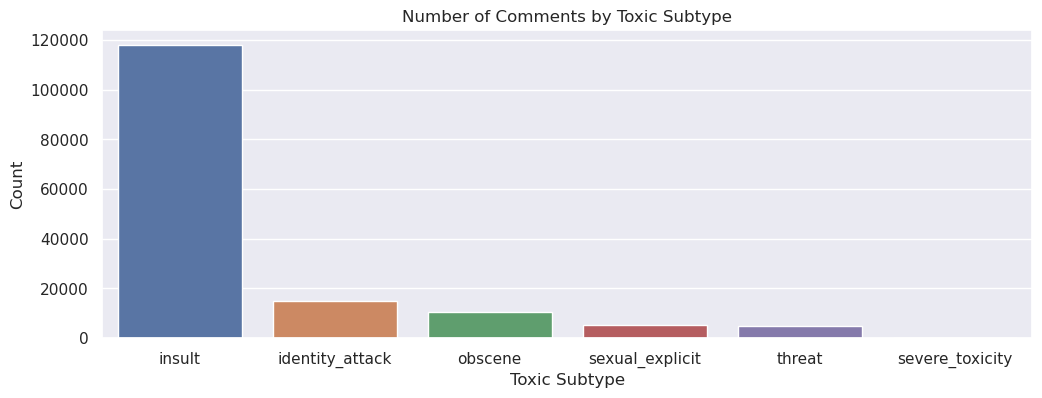

In [10]:
### Distribution of toxic subtype
sns.barplot(data = df_melt, x = "toxic_subtype", y = "value", 
            order = ["insult", "identity_attack", "obscene", "sexual_explicit", "threat", "severe_toxicity"],
            estimator = np.sum, errorbar = None)
plt.title("Number of Comments by Toxic Subtype")
plt.xlabel("Toxic Subtype")
plt.ylabel("Count")
plt.show()

# CREATE TRAIN & TEST SETS

BERT is a large NN architecture. Amazon Sagemaker's free GPU cannot handle perform BERT's pre-processing on the entire data frame because of RAM. Lets sample the DataFrame to ensure we can pre-process the data and fine-tune the model

In [11]:
def sample_dataframe(df, n_sample):
    """Samples the DataFrame"""
    rng = np.random.RandomState(123) 

    sample_df = df.sample(n = n_sample, replace = False, random_state = rng)
    df_train, df_test = train_test_split(sample_df, train_size = 0.70, random_state = rng)
    return(df_train, df_test)

In [12]:
df_train, df_test = sample_dataframe(df, n_sample = 1000)
print(df_train.shape, df_test.shape)


(700, 19) (300, 19)


# TEXT CLASSIFICATION

Create functions to pre-process data as well as create and fine-tune BERT model

In [13]:
def load_model_tokenizer():
    """Loads BERT tokenizer"""
    tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
    return tokenizer


In [14]:
def preprocess_data(df, tokenizer):
    """Pre-processes the data"""
    comment_list = df["comment_text_cleaned"].tolist()

    tokenized_data = tokenizer(comment_list, return_tensors = "np", padding = True, truncation = True)
    tokenized_data = dict(tokenized_data) # tokenizer object returns BatchEncoding. Convert it to a dict for Keras

    labels = np.array(df[["severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]])

    return(tokenized_data, labels)

In [15]:
def create_model(n_class = 6):
    """Loads BERT model"""
    tf.random.set_seed(123)
    tf.keras.backend.clear_session()
    input_ids = Input(shape = (None,), dtype = tf.int32, name = "input_ids")
    input_type = Input(shape = (None,), dtype = tf.int32, name = "token_type_ids")
    input_mask = Input(shape = (None,), dtype = tf.int32, name = "attention_mask")
    inputs = [input_ids, input_type, input_mask]
    bert = TFBertModel.from_pretrained("bert-base-cased")
    bert_outputs = bert(inputs)
    last_hidden_states = bert_outputs.last_hidden_state
    avg = GlobalAveragePooling1D()(last_hidden_states)
    output = Dense(n_class, activation = "sigmoid")(avg)
    model = Model(inputs = inputs, outputs = output)

    return model

In [16]:
def fine_tune_model(model, x, y, n_epoch = 5):
    """Fine-tunes the model"""
    n_patience = np.ceil(n_epoch * 0.20)
    es = EarlyStopping(monitor = "loss", patience = n_patience, restore_best_weights = True)
    mc = ModelCheckpoint("Model/mod.h5", monitor = "loss", save_best_only = True)

    model.compile(optimizer = Adam(3e-5), loss = tf.keras.losses.BinaryCrossentropy())
    model.fit(x, y, epochs = n_epoch, callbacks = [es, mc])

    return model

Implement functions

In [17]:
### Load tokenizer
tokenizer = load_model_tokenizer()

In [18]:
### Pre-process train and test sets
X_train, Y_train = preprocess_data(df_train, tokenizer)
X_test, Y_test = preprocess_data(df_test, tokenizer)

In [19]:
### Create model
model = create_model()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
### Fine-tune model
model = fine_tune_model(model, X_train, Y_train)

Epoch 1/5
22/22 [==============================] - 69s 1s/step - loss: 0.1350
Epoch 2/5
22/22 [==============================] - 33s 1s/step - loss: 0.0947
Epoch 3/5
22/22 [==============================] - 31s 1s/step - loss: 0.0987


Evaluate model

In [21]:
### Score model
model.evaluate(X_test, Y_test)

10/10 [==============================] - 6s 382ms/step - loss: 0.0910


0.09097244590520859

In [22]:
### Get predictions
yhat = model.predict(X_test)
df_yhat = pd.DataFrame(yhat, columns = ["severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]).add_suffix("_yhat")

10/10 [==============================] - 6s 378ms/step


In [23]:
df_test = df_test[["comment_text", "severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]].reset_index().drop(columns = "index").copy()
df_test = pd.concat([df_test, df_yhat], axis = 1)

In [25]:
def calculate_kl_divergence(df, columns):
    """Calculates KL Divergence"""
    df_kl = pd.DataFrame()
    kl = tf.keras.losses.KLDivergence()

    for col in columns:
        y_true = col
        y_hat = col + "_yhat"

        kl_divergence = kl(df[y_true], df[y_hat]).numpy()

        df_i = pd.DataFrame({"toxic_subtype": col, "kl_divergence": kl_divergence}, index = [0])
        df_kl = pd.concat([df_kl, df_i])

    return(df_kl)

In [26]:
cols = ["severe_toxicity", "obscene", "sexual_explicit", "identity_attack", "insult", "threat"]
df_kl = calculate_kl_divergence(df_test, cols)
df_kl

,toxic_subtype,kl_divergence
0,severe_toxicity,4.595905
0,obscene,10.764425
0,sexual_explicit,1.924864
0,identity_attack,6.863667
0,insult,47.817329
0,threat,16.286493
